<a href="https://colab.research.google.com/github/AlirezaGhavidel70/AI-based-bridge-network-analysis/blob/main/Network_analysis_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
## This code provide the suggested maintenace actions by AI-based policy for network bridge managment
### user inputs for analysis  #####
import sympy
from sympy import *
import torch.nn as nn
import pandas as pd
import numpy as np

budget_ratio = 0.010  # budget ration for each year to multiply the total amount of construction (all bridges in the network)
cumulative_budget = True # if you want to use the remained budget from the previous year to the next year please put "True", otherwise the remained budget is not transferr to the next year "False"
workforce_ratio = 0.1   #This ratio restricts the number of bridges that can be maintained each year within the total bridge network.
### Bridge parameters ##########

C_b = 160.19  # Bridge construction cost rate $/ft2 deck area
# units in the excel file: Deck area = square meter, Ld (detour length) = km
file_path = '/content/drive/MyDrive/bridge_parameters.xlsx'  # Replace with your file's path
sheet_name = 'Sheet1'  # Replace with your sheet name if needed
x= Symbol('x')
# hazard curve for location (in this case Memphis)
y2= 11.8246*sympy.exp(56.1606*((sympy.log(x/134.7200))**-1)) # it is for Memphis (you can put the seismic hazard curve)




In [2]:

# Read the Excel file into a DataFrame
df = pd.read_excel(file_path, sheet_name=sheet_name)
deck_area_Net= df['deck'].to_numpy()
L_d_Net = df['Ld'].to_numpy()
ADT_Net = df['ADT'].to_numpy()
r_Truck_Net = df['r'].to_numpy()
columns_to_read = ['CR deck', 'CR super', 'CR sub']  # Specify the column letters
df_initial = pd.read_excel(file_path, usecols=columns_to_read)
# Convert the DataFrame into the desired array format
initial_state = df_initial.to_numpy().tolist()
initial_state = np.asarray(initial_state)-1
Centrality = df['Centrality'].to_numpy()
start_x = df['Start_x'].to_numpy()
start_y = df['Start y'].to_numpy()
C_b = C_b * 10.764   # convert to $/m2

In [3]:
### call the required packages from library #####
!pip install contextily
import math
from copy import deepcopy
from sklearn import preprocessing
import pandas as pd
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
import numpy as np
from operator import itemgetter
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from shapely.geometry import Point
import time
from gym import Env
from gym.spaces import Discrete, Box
import numpy as np
import random
import matplotlib.pyplot as plt
from copy import deepcopy

import scipy
import sympy
from scipy import special
from sympy import *
from scipy.misc import derivative
from scipy import *
from scipy.stats import lognorm
from scipy.optimize import minimize, rosen, rosen_der
from scipy import special
from scipy.stats import norm

import folium
from folium.plugins import MarkerCluster
import geopandas as gpd
num_statistic = 1   # number of episodes
years=1  # life time horizon
times = [0]  # pick some times to show the results for those specific years (you can choose any year you want and the length of array can be vary)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 36.2 MB/s eta 0:00:00


In [4]:

#### Paret Frontier ranking ########
class Ranking_AG:

    def __init__(self, Q_values, states_sys,centrality_parameter):
        self.Q_values = Q_values
        self.states_sys = states_sys
        self. between = centrality_parameter



    def simple_cull(self, inputPoints, dominates):
        paretoPoints = set()
        candidateRowNr = 0
        dominatedPoints = set()
        while True:
            candidateRow = inputPoints[candidateRowNr]
            inputPoints.remove(candidateRow)
            rowNr = 0
            nonDominated = True
            while len(inputPoints) != 0 and rowNr < len(inputPoints):
                row = inputPoints[rowNr]
                if dominates(candidateRow, row):
                    inputPoints.remove(row)
                    dominatedPoints.add(tuple(row))
                elif dominates(row, candidateRow):
                    nonDominated = False
                    dominatedPoints.add(tuple(candidateRow))
                    rowNr += 1
                else:
                    rowNr += 1

            if nonDominated:
                paretoPoints.add(tuple(candidateRow))

            if len(inputPoints) == 0:
                break
        return paretoPoints, dominatedPoints

    def dominates(self, row, candidateRow):
        return sum([row[x] >= candidateRow[x] for x in range(len(row))]) == len(row)

    def process_data(self, pareto_frontier_df):

        pareto_frontier_df.iloc[:, 0] = self.between
        pareto_frontier_df.iloc[:, 1] = self.states_sys
        pareto_frontier_df.iloc[:, 2] = self.Q_values
        # Generate a sequence of IDs and add as a new column
        id_arr = np.linspace(0, len(pareto_frontier_df) - 1, len(pareto_frontier_df))

        pareto_frontier_df["id_col"] = id_arr
        self.temp_df = pareto_frontier_df
        # Convert the DataFrame to a list of lists (for Pareto analysis)
        costs = pareto_frontier_df.to_numpy()[:,:].tolist()

        # Define cost labels (3 inputs)
        cost1 = "Betweenness"
        cost2 = "State_sys"
        cost3 = "Q_values"

        # Perform Pareto analysis
        paretoPoints, dominatedPoints = self.simple_cull(costs, self.dominates)
        #print('dominatedPoints', len(dominatedPoints))

        # Rank the Pareto points
        arr, lastRank = self.ranking(pareto_frontier_df, paretoPoints, cost1, cost2, cost3, 0)

        # Loop through all sets of Pareto points to rank all nodes
        fullArr = list(arr)
        iteration_count = 1  # Initialize the iteration count
        while lastRank < len(pareto_frontier_df):
            for nodesNum in arr[:, 0]:
                self.temp_df = self.temp_df[self.temp_df.id_col != nodesNum]
            costs = self.temp_df.to_numpy().tolist()
            paretoPoints, dominatedPoints = self.simple_cull(costs, self.dominates)
            arr, lastRank = self.ranking(pareto_frontier_df, paretoPoints, cost1, cost2, cost3, lastRank)
            fullArr.extend(list(arr))
            iteration_count += 1  # Increment the iteration count


        # Convert the full array to a numpy array and sort by the final rank
        fullArr = np.array(fullArr)
        fullArr = fullArr[fullArr[:, -1].argsort()]

        return fullArr[:, 0]

    def rankingParam(self, paretoPoints, x, y, z):
        EuclidDist = []
        for k in range(len(paretoPoints)):
            EuclidDist.append(np.sqrt((list(paretoPoints)[k][0] - x)**2 +
                                      (list(paretoPoints)[k][1] - y)**2 +
                                      (list(paretoPoints)[k][2] - z)**2))
        return sum(EuclidDist)

    def ranking(self, pareto_frontier_df, paretoPoints, cost1, cost2, cost3, lastRank):
        a = []
        for i in range(len(paretoPoints)):
            for j in pareto_frontier_df[(pareto_frontier_df[cost1] == list(paretoPoints)[i][0]) &
                                        (pareto_frontier_df[cost2] == list(paretoPoints)[i][1]) &
                                        (pareto_frontier_df[cost3] == list(paretoPoints)[i][2])]["id_col"]:
                n = j
                x = list(paretoPoints)[i][0]
                y = list(paretoPoints)[i][1]
                z = list(paretoPoints)[i][2]
                r = self.rankingParam(paretoPoints, x, y, z)
                a.append([n, x, y, z, r])
        arr = np.array(a)
        arr = arr[arr[:, 4].argsort()]
        ranks = np.arange(np.size(arr, 0) + lastRank, lastRank, -1)
        ranks = np.reshape(ranks, (-1, 1))
        arr = np.hstack((arr, ranks))
        return arr, arr[0, -1]


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
# -*- coding: utf-8 -*-

# Fragility models and risk assessment

class FRAG_DRL:

    def __init__(self, time_t=[], jacket_time=[], extender_time=[], shearKey_time=[], RC_time=[], EB_time=[]):


        self.time_t=np.array(time_t)
        self.extender_time=np.array(extender_time)
        self.jacket_time= np.array(jacket_time)
        self.shearKey_time= np.array(shearKey_time)
        self.RC_time= np.array(RC_time)
        self.EB_time= np.array(EB_time)


    def mod_frag(pf,x,mod_factors):

        f = lambda x,mu,sigma: scipy.stats.lognorm.cdf(x, sigma, loc=0, scale=np.exp(mu))
        #x0 = np.asarray([np.log(1.5), 0.5])
        x0 = np.asarray([np.log(1.5), 0.001])
        mu,sigma = scipy.optimize.curve_fit(f,x,pf,p0=x0,method='lm',maxfev=5000)[0]
        mu=np.log(np.exp(mu)*mod_factors[0])
        sigma=sigma*mod_factors[1]
        pf_mod = scipy.stats.lognorm.cdf(x, sigma, loc=0, scale=np.exp(mu))
        return pf_mod, mu,sigma


    def fraglity (self,):

        frag_mod_factors_SJ= [1.03,1,1.16,1,1.17,1,1.20,1]
        frag_mod_factors_EB= [2.94,1,1.31,1,1.21,1,1.17,1]
        frag_mod_factors_RC= [1.04,1,0.96,1,1.01,1,1.05,1]
        frag_mod_factors_SE= [1.01,1,1.00,1,1.00,1,1.31,1]
        frag_mod_factors_SK= [1.01,1,0.98,1,0.99,1,1.01,1]
        frag_mod_factors_RC_SK= [1.04,1,0.96,1,1.04,1,1.12,1]
        frag_mod_factors_SE_SK= [1.01,1,0.97,1,0.99,1,1.37,1]
        frag_mod_factors_SJ_SE= [1.03,1,1.16,1,1.17,1,1.31,1]
        frag_mod_factors_SJ_SK= [1.03,1,1.16,1,1.17,1,1.37,1]
        frag_mod_factors_SJ_SE_SK=[1.03,1,1.16,1,1.17,1,1.37,1]



        PGA=np.linspace(np.log(0.01), np.log(3), 30)
        PGA=np.exp(PGA)
        size=PGA.size



        lam_factor_complete_sys= np.zeros(size)
        lam_factor_extensive_sys= np.zeros(size)
        lam_factor_moderate_sys= np.zeros(size)
        lam_factor_slight_sys= np.zeros(size)




        P_slight_sys = norm.cdf((np.log(PGA)-np.log(0.21))/0.69)
        P_moderate_sys = norm.cdf((np.log(PGA)-np.log(0.61))/0.60)
        P_extensive_sys = norm.cdf((np.log(PGA)-np.log(0.86))/0.60)
        P_complete_sys = norm.cdf((np.log(PGA)-np.log(1.20))/0.61)





        x= Symbol('x')
        #y2= 11.8246*sympy.exp(56.1606*((sympy.log(x/134.7200))**-1)) # it is for Memphis (you can put the seismic hazard curve)
        y2prime=y2.diff(x)
        yprime=y2prime
        f = lambdify(x, yprime, 'numpy')

        s=np.zeros(size)
        s1 = np.zeros(size)



        lam_factor_complete_sys= np.zeros(size)
        lam_factor_extensive_sys= np.zeros(size)
        lam_factor_moderate_sys= np.zeros(size)
        lam_factor_slight_sys= np.zeros(size)



        for sa in range (0,size):
            s[sa]=np.abs(f(PGA[sa]))
            if sa!=0:
                s1[sa]=s[sa]*np.abs((PGA[sa]-PGA[sa-1]))


        if self.time_t>=self.extender_time and self.time_t>=self.jacket_time and self.time_t>=self.shearKey_time:


            #print('three')

            P_slight_sys = norm.cdf((np.log(PGA)-np.log(0.21*frag_mod_factors_SJ_SE_SK[0]))/(0.69*frag_mod_factors_SJ_SE_SK[1]))
            P_moderate_sys = norm.cdf((np.log(PGA)-np.log(0.61*frag_mod_factors_SJ_SE_SK[2]))/(0.60*frag_mod_factors_SJ_SE_SK[3]))
            P_extensive_sys = norm.cdf((np.log(PGA)-np.log(0.86*frag_mod_factors_SJ_SE_SK[4]))/(0.60*frag_mod_factors_SJ_SE_SK[5]))
            P_complete_sys = norm.cdf((np.log(PGA)-np.log(1.20*frag_mod_factors_SJ_SE_SK[6]))/(0.61*frag_mod_factors_SJ_SE_SK[7]))



            lam_factor_complete_sys= s1*P_complete_sys
            lam_factor_extensive_sys= s1*P_extensive_sys
            lam_factor_moderate_sys= s1*P_moderate_sys
            lam_factor_slight_sys= s1*P_slight_sys

        elif self.time_t>=self.extender_time and self.time_t>=self.jacket_time:


            #print('three')

            P_slight_sys = norm.cdf((np.log(PGA)-np.log(0.21*frag_mod_factors_SJ_SE[0]))/(0.69*frag_mod_factors_SJ_SE[1]))
            P_moderate_sys = norm.cdf((np.log(PGA)-np.log(0.61*frag_mod_factors_SJ_SE[2]))/(0.60*frag_mod_factors_SJ_SE[3]))
            P_extensive_sys = norm.cdf((np.log(PGA)-np.log(0.86*frag_mod_factors_SJ_SE[4]))/(0.60*frag_mod_factors_SJ_SE[5]))
            P_complete_sys = norm.cdf((np.log(PGA)-np.log(1.20*frag_mod_factors_SJ_SE[6]))/(0.61*frag_mod_factors_SJ_SE[7]))



            lam_factor_complete_sys= s1*P_complete_sys
            lam_factor_extensive_sys= s1*P_extensive_sys
            lam_factor_moderate_sys= s1*P_moderate_sys
            lam_factor_slight_sys= s1*P_slight_sys

        elif self.time_t>=self.shearKey_time and self.time_t>=self.jacket_time:


            P_slight_sys = norm.cdf((np.log(PGA)-np.log(0.21*frag_mod_factors_SJ_SK[0]))/(0.69*frag_mod_factors_SJ_SK[1]))
            P_moderate_sys = norm.cdf((np.log(PGA)-np.log(0.61*frag_mod_factors_SJ_SK[2]))/(0.60*frag_mod_factors_SJ_SK[3]))
            P_extensive_sys = norm.cdf((np.log(PGA)-np.log(0.86*frag_mod_factors_SJ_SK[4]))/(0.60*frag_mod_factors_SJ_SK[5]))
            P_complete_sys = norm.cdf((np.log(PGA)-np.log(1.20*frag_mod_factors_SJ_SK[6]))/(0.61*frag_mod_factors_SJ_SK[7]))



            lam_factor_complete_sys= s1*P_complete_sys
            lam_factor_extensive_sys= s1*P_extensive_sys
            lam_factor_moderate_sys= s1*P_moderate_sys
            lam_factor_slight_sys= s1*P_slight_sys
        elif self.time_t>=self.extender_time and self.time_t>=self.shearKey_time:


            P_slight_sys = norm.cdf((np.log(PGA)-np.log(0.21*frag_mod_factors_SE_SK[0]))/(0.69*frag_mod_factors_SE_SK[1]))
            P_moderate_sys = norm.cdf((np.log(PGA)-np.log(0.61*frag_mod_factors_SE_SK[2]))/(0.60*frag_mod_factors_SE_SK[3]))
            P_extensive_sys = norm.cdf((np.log(PGA)-np.log(0.86*frag_mod_factors_SE_SK[4]))/(0.60*frag_mod_factors_SE_SK[5]))
            P_complete_sys = norm.cdf((np.log(PGA)-np.log(1.20*frag_mod_factors_SE_SK[6]))/(0.61*frag_mod_factors_SE_SK[7]))



            lam_factor_complete_sys= s1*P_complete_sys
            lam_factor_extensive_sys= s1*P_extensive_sys
            lam_factor_moderate_sys= s1*P_moderate_sys
            lam_factor_slight_sys= s1*P_slight_sys

        elif self.time_t>=self.RC_time and self.time_t>=self.shearKey_time:


            P_slight_sys = norm.cdf((np.log(PGA)-np.log(0.21*frag_mod_factors_RC_SK[0]))/(0.69*frag_mod_factors_RC_SK[1]))
            P_moderate_sys = norm.cdf((np.log(PGA)-np.log(0.61*frag_mod_factors_RC_SK[2]))/(0.60*frag_mod_factors_RC_SK[3]))
            P_extensive_sys = norm.cdf((np.log(PGA)-np.log(0.86*frag_mod_factors_RC_SK[4]))/(0.60*frag_mod_factors_RC_SK[5]))
            P_complete_sys = norm.cdf((np.log(PGA)-np.log(1.20*frag_mod_factors_RC_SK[6]))/(0.61*frag_mod_factors_RC_SK[7]))



            lam_factor_complete_sys= s1*P_complete_sys
            lam_factor_extensive_sys= s1*P_extensive_sys
            lam_factor_moderate_sys= s1*P_moderate_sys
            lam_factor_slight_sys= s1*P_slight_sys

        elif self.time_t>=self.shearKey_time:


            P_slight_sys = norm.cdf((np.log(PGA)-np.log(0.21*frag_mod_factors_SK[0]))/(0.69*frag_mod_factors_SK[1]))
            P_moderate_sys = norm.cdf((np.log(PGA)-np.log(0.61*frag_mod_factors_SK[2]))/(0.60*frag_mod_factors_SK[3]))
            P_extensive_sys = norm.cdf((np.log(PGA)-np.log(0.86*frag_mod_factors_SK[4]))/(0.60*frag_mod_factors_SK[5]))
            P_complete_sys = norm.cdf((np.log(PGA)-np.log(1.20*frag_mod_factors_SK[6]))/(0.61*frag_mod_factors_SK[7]))



            lam_factor_complete_sys= s1*P_complete_sys
            lam_factor_extensive_sys= s1*P_extensive_sys
            lam_factor_moderate_sys= s1*P_moderate_sys
            lam_factor_slight_sys= s1*P_slight_sys


        elif self.time_t>=self.extender_time:


            P_slight_sys = norm.cdf((np.log(PGA)-np.log(0.21*frag_mod_factors_SE[0]))/(0.69*frag_mod_factors_SE[1]))
            P_moderate_sys = norm.cdf((np.log(PGA)-np.log(0.61*frag_mod_factors_SE[2]))/(0.60*frag_mod_factors_SE[3]))
            P_extensive_sys = norm.cdf((np.log(PGA)-np.log(0.86*frag_mod_factors_SE[4]))/(0.60*frag_mod_factors_SE[5]))
            P_complete_sys = norm.cdf((np.log(PGA)-np.log(1.20*frag_mod_factors_SE[6]))/(0.61*frag_mod_factors_SE[7]))



            lam_factor_complete_sys= s1*P_complete_sys
            lam_factor_extensive_sys= s1*P_extensive_sys
            lam_factor_moderate_sys= s1*P_moderate_sys
            lam_factor_slight_sys= s1*P_slight_sys

        elif self.time_t>=self.RC_time:


            P_slight_sys = norm.cdf((np.log(PGA)-np.log(0.21*frag_mod_factors_RC[0]))/(0.69*frag_mod_factors_RC[1]))
            P_moderate_sys = norm.cdf((np.log(PGA)-np.log(0.61*frag_mod_factors_RC[2]))/(0.60*frag_mod_factors_RC[3]))
            P_extensive_sys = norm.cdf((np.log(PGA)-np.log(0.86*frag_mod_factors_RC[4]))/(0.60*frag_mod_factors_RC[5]))
            P_complete_sys = norm.cdf((np.log(PGA)-np.log(1.20*frag_mod_factors_RC[6]))/(0.61*frag_mod_factors_RC[7]))



            lam_factor_complete_sys= s1*P_complete_sys
            lam_factor_extensive_sys= s1*P_extensive_sys
            lam_factor_moderate_sys= s1*P_moderate_sys
            lam_factor_slight_sys= s1*P_slight_sys


        elif self.time_t>=self.EB_time:


            P_slight_sys = norm.cdf((np.log(PGA)-np.log(0.21*frag_mod_factors_EB[0]))/(0.69*frag_mod_factors_EB[1]))
            P_moderate_sys = norm.cdf((np.log(PGA)-np.log(0.61*frag_mod_factors_EB[2]))/(0.60*frag_mod_factors_EB[3]))
            P_extensive_sys = norm.cdf((np.log(PGA)-np.log(0.86*frag_mod_factors_EB[4]))/(0.60*frag_mod_factors_EB[5]))
            P_complete_sys = norm.cdf((np.log(PGA)-np.log(1.20*frag_mod_factors_EB[6]))/(0.61*frag_mod_factors_EB[7]))



            lam_factor_complete_sys= s1*P_complete_sys
            lam_factor_extensive_sys= s1*P_extensive_sys
            lam_factor_moderate_sys= s1*P_moderate_sys
            lam_factor_slight_sys= s1*P_slight_sys

        elif self.time_t>=self.jacket_time:


            P_slight_sys = norm.cdf((np.log(PGA)-np.log(0.21*frag_mod_factors_SJ[0]))/(0.69*frag_mod_factors_SJ[1]))
            P_moderate_sys = norm.cdf((np.log(PGA)-np.log(0.61*frag_mod_factors_SJ[2]))/(0.60*frag_mod_factors_SJ[3]))
            P_extensive_sys = norm.cdf((np.log(PGA)-np.log(0.86*frag_mod_factors_SJ[4]))/(0.60*frag_mod_factors_SJ[5]))
            P_complete_sys = norm.cdf((np.log(PGA)-np.log(1.20*frag_mod_factors_SJ[6]))/(0.61*frag_mod_factors_SJ[7]))



            lam_factor_complete_sys= s1*P_complete_sys
            lam_factor_extensive_sys= s1*P_extensive_sys
            lam_factor_moderate_sys= s1*P_moderate_sys
            lam_factor_slight_sys= s1*P_slight_sys



        else:


            lam_factor_complete_sys= s1*P_complete_sys
            lam_factor_extensive_sys= s1*P_extensive_sys
            lam_factor_moderate_sys= s1*P_moderate_sys
            lam_factor_slight_sys= s1*P_slight_sys




        annual_rate_slight_sys=sum(lam_factor_slight_sys)
        annual_rate_moderate_sys=sum(lam_factor_moderate_sys)
        annual_rate_extensive_sys=sum(lam_factor_extensive_sys)
        annual_rate_complete_sys=sum(lam_factor_complete_sys)





        PT_slight_sys=1-np.exp(-annual_rate_slight_sys)
        PT_moderate_sys=1-np.exp(-annual_rate_moderate_sys)
        PT_extensive_sys=1-np.exp(-annual_rate_extensive_sys)
        PT_complete_sys=1-np.exp(-annual_rate_complete_sys)



        PP_sys=[1-(PT_slight_sys), -PT_moderate_sys+PT_slight_sys, -PT_extensive_sys+PT_moderate_sys,-PT_complete_sys+PT_extensive_sys, PT_complete_sys]

        P_sys = PP_sys


        return P_sys



In [6]:


########### Defined Environment for the agents ##################

class BridgeEnvFrg(Env):
    def __init__(self, life):

        # lets consider the order as following for components:
        # "0": Deck, "1":Super structure, "2": Sub structure,
        # Actions we can take : Do nothing, Minor, Major and replacement
        self.action_space = Discrete(64) # 64: 4*4*4 actions //// 4 actions [do nothing, minor, major, replacement] for deck, superstructure and substructure
        # observation array
        self.observation_space = Box(low=np.array([0, 0, 0]), high=np.array([8,8,8]), shape = (3,), dtype=np.int64) # [Deck 0-8, Sperstructure 0-8, Substructure 0-8, seismic component 0-4]
        # Set start state
        self.state = np.zeros(shape=(3,),dtype = np.int64)
        self.state[0:3] =  np.random.randint(2,[9,9,9])    #8, 4, 0 # initiating the initial state from the fair condition randomly
        self.total_steps = 0
        self.componenets = 3
        self.life = life
        self.damage = 0


    def step(self, action, Deck_area, L_d, ADT, r_Truck, jacketing = False, jacketing_t = 100, extender = False, extender_t = 100, shearKey = False, shearKey_t = 100, w1=0.05, w2=0.05,states = np.zeros(shape=(3,),dtype = np.int64)):

        self.state= states
        state_old = deepcopy(self.state)
        trans = np.zeros(shape=[self.componenets,4,9,9])  # 3 comps, 4 actions, 9 states
        # Do nothing
        trans [0, 0] = [[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
                        [0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
                        [0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
                        [0.0000, 0.0000, 0.0114, 0.9886, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
                        [0.0000, 0.0000, 0.0000, 0.0174, 0.9826, 0.0000, 0.0000, 0.0000, 0.0000],
                        [0.0000, 0.0000, 0.0000, 0.0000, 0.0227, 0.9773, 0.0000, 0.0000, 0.0000],
                        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0268, 0.9732, 0.0000, 0.0000],
                        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0714, 0.9286, 0.0000],
                        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0452, 0.1011, 0.8537]]

        trans [1, 0] = [[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
                        [0.0282, 0.9718, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
                        [0.0000, 0.0107, 0.9893, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
                        [0.0000, 0.0000, 0.0147, 0.9853, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
                        [0.0000, 0.0000, 0.0000, 0.0194, 0.9806, 0.0000, 0.0000, 0.0000, 0.0000],
                        [0.0000, 0.0000, 0.0000, 0.0000, 0.0246, 0.9754, 0.0000, 0.0000, 0.0000],
                        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0276, 0.9724, 0.0000, 0.0000],
                        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0532, 0.9468, 0.0000],
                        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0282, 0.0995, 0.8723]]

        trans [2, 0] = [[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
                        [0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
                        [0.0000, 0.0142, 0.9858, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
                        [0.0000, 0.0000, 0.0208, 0.9792, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
                        [0.0000, 0.0000, 0.0000, 0.0302, 0.9698, 0.0000, 0.0000, 0.0000, 0.0000],
                        [0.0000, 0.0000, 0.0000, 0.0000, 0.0282, 0.9718, 0.0000, 0.0000, 0.0000],
                        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0207, 0.9793, 0.0000, 0.0000],
                        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0654, 0.9346, 0.0000],
                        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0349, 0.0925, 0.8726]]


        # Minor maintenance # we changed it in task 3
        trans [0:3, 1] = [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                          [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                          [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                          [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                          [0.0, 0.0, 0.0, 0.0, 0.9, 0.1, 0.0, 0.0, 0.0],
                          [0.0, 0.0, 0.0, 0.0, 0.0, 0.80, 0.20, 0.0, 0],
                          [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7, 0.3, 0.0],
                          [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.6, 0.4],
                          [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]]

        # Major Maintenance
        trans [0:3, 2] = [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                          [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                          [0.0, 0.0, 0.3, 0.4, 0.3, 0.0, 0.0, 0.0, 0.0],
                          [0.0, 0.0, 0.0, 0.1, 0.3, 0.6, 0.0, 0.0, 0.0],
                          [0.0, 0.0, 0.0, 0.0, 0.1, 0.2, 0.7, 0.0, 0.0],
                          [0.0, 0.0, 0.0, 0.0, 0.0, 0.05, 0.1, 0.85, 0],
                          [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.05, 0.05, 0.9],
                          [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0.02, 0.98],
                          [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]]



        # Replace
        trans [0:3,3,:,8] = 1

        #trans [0:3, 0:3]=np.identity(9)  # This is just when we want to check the effect of just fragility (ignor natural deterioration)

        # unravel actions
        action_index = np.unravel_index(action,(4,4,4))  # (deck, superstructure, substructure, column, bearing, abutment, retrofitting combinations )
        action_index = np.asarray(action_index)


        #state_old = deepcopy(self.state)

        # DS only reflect the DS happened in each year based on the seismic risk model. We don't propagate the DS to the next year
        self.damage = 0


        # for extender retrofitting (bearing)
        if extender == True:
            self.extender_time = extender_t
        else:
            self.extender_time = []
        if jacketing == True:
            self.jacket_time = jacketing_t
        else:
            self.jacket_time = []
        if shearKey == True:
            self.shearKey_time = shearKey_t
        else:
            self.shearKey_time = []



        FRG=FRAG_DRL(time_t=self.total_steps, jacket_time=self.jacket_time, extender_time=self.extender_time, shearKey_time=self.shearKey_time, RC_time=[], EB_time=[])
        P_sys=FRG.fraglity()



        # this part the next state is calculated based on the transition probabilities come from Markov matrices and fragility functions

        for component in range(self.componenets):
            self.state[component] = np.random.choice(9, p=trans[component][action_index[component]][self.state[component]])


        self.damage = np.random.choice(5, p=P_sys)





####################################################################################
        # Mapping DS to CR
        state_update = deepcopy(self.state)

        if self.damage == 0:
            self.state[0] = state_update[0]
            self.state[1] = state_update[1]
            self.state[2] = state_update[2]

        elif self.damage == 1:
            self.state[0] = np.min([state_update[0],6])
            self.state[1] = np.min([state_update[1],6])
            self.state[2] = np.min([state_update[2],6])

        elif self.damage == 2:
            self.state[0] = np.min([state_update[0],4])
            self.state[1] = np.min([state_update[1],4])
            self.state[2] = np.min([state_update[2],4])

        elif self.damage == 3:
            self.state[0] = np.min([state_update[0],3])
            self.state[1] = np.min([state_update[1],3])
            self.state[2] = np.min([state_update[2],3])

        elif self.damage == 4:
            self.state[0] = 0
            self.state[1] = 0
            self.state[2] = 0


####################################################################################

        # update CS based on actions

        if action_index[1]==3:
            self.state[0]=8
            self.state[1]=8
        if action_index[2]==3:
            self.state[0] = 8
            self.state[1] = 8
            self.state[2] = 8



        """Calculate reward'"""
        # for better interpretation of results seperate the costs related to maintenance, repair and retrofit costs
        # Residual serviceability based on current action (what about retroft actions????? check with Dr. DU)
        if max(action_index[0:3]) ==0: # Do nothing
            T1 = 0.0
            alpha1 = 1.0
            T_DN = 0.0
            alpha_DN = 1.0
        elif max(action_index[0:3])==1: # Minor maintenance
            T1 = 7.0
            alpha1 = 0.75
            T_M = 7.0
            alpha_M = 0.75
        elif max(action_index[0:3])==2: # Major maintenance
            T1 = 30.0
            alpha1 = 0.5
            T_M = 30.0
            alpha_M = 0.5
        else:                           # replace
            T1 = 182.0
            alpha1 = 0.0
            T_M = 182.0
            alpha_M = 0.0

        T_CR = T1
        alpha_CR = alpha1



        # final T and alpha from different maintenance actions and different damage states
        T = T_CR
        alpha = alpha_CR


        # Bridge total construction costs
        #C_b = 160.19 * 10.764 # Bridge construction cost rate $/ft2 deck area

        #Deck_Area = self.num_spans * self.span_length * self.deck_width * (0.083*0.083)
        C_Bridge = Deck_area*C_b  # 10.764 convert from meter square to feet square
        steel_jacketing_unit = 0.12  #
        C_jacketing = steel_jacketing_unit *  C_Bridge  #steel_jacketing_unit * self.num_col
        C_seat_extender= 0.03 * C_Bridge # 517.5 *self.num_girders*2 + 4140 # num _girder1.38 * 375 * num_girder * 2 + 1.38* 3000  # I guess it should be: 1.38 * 375 *(num_spans-1)*2 + 1.38 * 3000 # 38 % cumulative inflation rate from 2008 to 2022
        C_shear_key= 0.03 * C_Bridge
        C_bearing = 0.05 * C_Bridge#536 * self.num_girders * 2 + 5120 * self.num_spans #1.28 * 418.75 * num_girder * 2 + 1.28 * 4000 * num_spans  # I guess it should be: 1.28*418.75 * (num_spans-1) * 2 + 1.28* 4000 * num_spans  # 28 % cumulative inflation rate from 2008 to 2022
        """ Direct agency costs """
        Cost_matrix = np.zeros(shape=(3,4))
        #Cost_matrix = np.zeros(shape=(7,5))
        Cost_matrix[0:3,0] = 0.0                                    # Components: Deck, superstructure, substructure, column, bearing snd abutment / action: do nothing
        Cost_matrix[0,1] = 0.05*C_Bridge * 0.225                    # Components: Deck / action: minor
        Cost_matrix[1,1] = 0.05*C_Bridge * 0.263                    # Components: superstructure  / action: minor
        Cost_matrix[2,1] = 0.05*C_Bridge * 0.412                    # Components: substructure / action: minor
        Cost_matrix[0,2] = 0.25*C_Bridge * 0.225                    # Components: Deck / action: major
        Cost_matrix[1,2] = 0.25*C_Bridge * 0.263                    # Components: superstructure / action: major
        Cost_matrix[2,2] = 0.25*C_Bridge * 0.412                    # Components: substructure / action: major
        Cost_matrix[0,3] = 1.1*C_Bridge * 0.225                     # Components: Deck / action: rebuild
        Cost_matrix[1,3] = 1.1*C_Bridge * (0.263 + 0.225)           # Components: superstructure / action: rebuild
        Cost_matrix[2,3] = 1.1*C_Bridge * (0.412 + 0.263 + 0.225)   # Components: substructure / action: rebuild


        C_CR = 0.0
        C_Ret = 0.0
        for i in range(0,3):  # Summation over all the 3 components
            C_CR += Cost_matrix[i,int(action_index[i])]

        C_j = 0.0
        C_ex= 0.0
        C_sk = 0.0
        if jacketing == True and self.total_steps==np.asarray(self.jacket_time):
            C_j = C_jacketing
        else:
            C_j=0.0

        if extender == True and self.total_steps==np.asarray(self.extender_time):
            C_ex = C_seat_extender
        else:
            C_ex = 0.0

        if shearKey == True and self.total_steps==np.asarray(self.shearKey_time):
            C_sk = C_shear_key
        else:
            C_sk = 0.0

        C_Ret = C_j + C_ex + C_sk
        C_Direct = 0
        C_Direct = C_CR + C_Ret


        if C_Direct > 1.1*C_Bridge:   # Avoid double counting the reconstruction action
            C_Direct = 1.1*C_Bridge
        """ Indirect social costs """
        #r_Truck = 0.10
        L_d = L_d * 0.621371     # 0.621371 converts km to mile
        #ADT = 10000     # 10000 or 5000
        C_O_Car = 0.64 # Running cost for car ($/car/mile)
        C_O_Truck = 1.855 # Running cost for truck ($/truck/mile)
        C_W_Car = 12.35 # Time costs for car passengers ($/hr/passenger)
        C_W_Truck = 31.05 # Time costs for trucks ($/hr/truck)
        O_Car = 1.67 # Number of passengers per car
        V_d = 50 # Detour speed mph
        # Determine percentage of detoured traffic due to serviceability loss (before the action)

        ### Note: please modify this part in the later version

        if state_old[0] >= 6: # deck
            phi_deck_old = 1
        elif state_old[0] >= 4 and state_old[0] < 6: # Deck
            phi_deck_old = 1 - (((6-state_old[0])/6)*0.75)
        else:
            phi_deck_old = 0.0

        if state_old[1] >= 4: # Superstructure
            phi_girder_old = 1.0
        else:
            phi_girder_old = 0.0

        if state_old[2] >= 4: # Substructure
            phi_sub_old = 1.0
        else:
            phi_sub_old = 0.0

        phi_old1 = min(phi_deck_old,phi_girder_old,phi_sub_old)


        phi_old = phi_old1

        # Indirect operation costs for all

        C_O = (C_O_Car*(1-r_Truck) + C_O_Truck*r_Truck)*L_d*ADT*((1-alpha*phi_old)*T + (1-phi_old)*(365-T))
        # Indirect time costs
        C_T = (C_W_Car*O_Car*(1-r_Truck) + C_W_Truck*r_Truck)*ADT*L_d/V_d*((1-alpha*phi_old)*T + (1-phi_old)*(365-T))
        # Total indirect costs
        C_Indirect = C_O + C_T


        # Indirect operation costs for CR no maintenance
        if max(action_index[0:3]) ==0:
            T = T_DN
            alpha = alpha_DN
            C_O = (C_O_Car*(1-r_Truck) + C_O_Truck*r_Truck)*L_d*ADT*((1-alpha*phi_old)*T + (1-phi_old)*(365-T))
            # Indirect time costs
            C_T = (C_W_Car*O_Car*(1-r_Truck) + C_W_Truck*r_Truck)*ADT*L_d/V_d*((1-alpha*phi_old)*T + (1-phi_old)*(365-T))
            # Total indirect costs
            C_Indirect_CR_DN = C_O + C_T
        else:
            C_Indirect_CR_DN =0.0


        # Indirect operation costs for CR with a maintenance
        if max(action_index[0:3]) >0:
            T = T_M
            alpha = alpha_M
            C_O = (C_O_Car*(1-r_Truck) + C_O_Truck*r_Truck)*L_d*ADT*((1-alpha*phi_old)*T + (1-phi_old)*(365-T))
            # Indirect time costs
            C_T = (C_W_Car*O_Car*(1-r_Truck) + C_W_Truck*r_Truck)*ADT*L_d/V_d*((1-alpha*phi_old)*T + (1-phi_old)*(365-T))
            # Total indirect costs
            C_Indirect_CR_M = C_O + C_T
        else:
            C_Indirect_CR_M = 0.0


        # Indirect operation costs for CR
        T = T1
        alpha = alpha1
        C_O = (C_O_Car*(1-r_Truck) + C_O_Truck*r_Truck)*L_d*ADT*((1-alpha*phi_old)*T + (1-phi_old)*(365-T))
        # Indirect time costs
        C_T = (C_W_Car*O_Car*(1-r_Truck) + C_W_Truck*r_Truck)*ADT*L_d/V_d*((1-alpha*phi_old)*T + (1-phi_old)*(365-T))
        # Total indirect costs
        C_Indirect_CR = C_O + C_T




        # Calculate reward
        C_Indirect_CR_DN = 1.43 * C_Indirect_CR_DN
        C_Indirect_CR_M = 1.43 * C_Indirect_CR_M
        C_Indirect_CR = 1.43 * C_Indirect_CR
        #C_Indirect_DS = 1.43 * C_Indirect_DS
        C_Indirect = C_Indirect_CR
        reward = -(C_Direct + (w1 * C_Indirect_CR))

        #agency_weight = 0.1
        #reward = -(C_Direct + agency_weight*C_Indirect)  # Negative of the total cost as the reward
        #print(reward)




         # go to the next year
        self.total_steps +=1

        # Check it is done
        if self.total_steps  == self.life:
            done = True
        else:
            done = False

        # Set placeholder for info
        info = {}

        # Return step information
        #return self.state, reward, done, info
        return self.state, reward, done, info, C_Direct, C_Indirect, self.damage, phi_old
        #return self.state, C_Direct, C_CR, C_DS, C_Ret, C_Indirect, C_Indirect_CR, C_Indirect_DS, reward, done, info
        #return self.state, C_Direct, C_Indirect,reward, done, info


    def render(self):
        # Implement viz
        pass

    def reset(self):
        self.state = np.zeros(shape=(3,),dtype = np.int64)
        self.state[0:3] = np.random.randint(2,[9,9,9])    #8, 4, 0
        self.total_steps = 0
        self.damage = 0

        return self.state




In [9]:
###### Bridge network level analysis using Multi AI-agent ########################



start_time = time.time()

env = BridgeEnvFrg(life= years)
gamma = 0.96
state_shape = env.observation_space.shape
n_params = int(4)


# if GPU is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Replay Memory
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward', 'A_deck','L_D','ADT','r_truck'))

BATCH_SIZE = 32
GAMMA = 0.96
EPS_START = 0
EPS_END = 0
EPS_DECAY = 5000
LR = 1e-2


# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
state = env.reset()
n_observations = len(state)

# DQN Agent
class DQN(nn.Module):

    def __init__(self, n_inputs, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_inputs, 24)
        self.layer2 = nn.Linear(24, 24)
        self.layer3 = nn.Linear(24, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)




########### Chek this part ###########################################################################################

w_1=0.05
w_2= 0.05

year_retrofit= 100

steel_lacketing = False
time_jacketing= 100
seat_extender = False
time_extender= 100
shear_key = False
time_shearKey= 100

action_vec=[0,0,0]

##### Trained AI agents ######
######### Load treained agents #############
policy_net1 = DQN(n_observations + n_params, n_actions)
policy_net1.load_state_dict(torch.load('/content/drive/MyDrive/Agent1.pth'))

policy_net2 = DQN(n_observations + n_params, n_actions)
policy_net2.load_state_dict(torch.load('/content/drive/MyDrive/Agent2.pth'))


policy_net3 = DQN(n_observations + n_params, n_actions)
policy_net3.load_state_dict(torch.load('/content/drive/MyDrive/Agent3.pth'))


policy_net4 = DQN(n_observations + n_params, n_actions)
policy_net4.load_state_dict(torch.load('/content/drive/MyDrive/Agent4.pth'))

policy_net5 = DQN(n_observations + n_params, n_actions)
policy_net5.load_state_dict(torch.load('/content/drive/MyDrive/Agent5.pth'))

policy_net1.eval()
policy_net2.eval()
policy_net3.eval()
policy_net4.eval()
policy_net5.eval()

def select_action(inputs):
    global i_bridge, previous_actions_deck, previous_actions_super, previous_actions_sub, ranks, i_budget, budget_flag, t, agent_selection, random_agent
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * i_bridge / EPS_DECAY)

    if sample == sample:
        with torch.no_grad():
            inputs_cpu = inputs.to('cpu').numpy()

            aa =np.random.randint(1,6,1)
            #aa=[10]
            agent_selection [i_bridge] = aa[0]
            #aa= random_agent
            if aa[0] == 1:
                action_values = policy_net1(inputs)
            if aa[0] == 2 :
                action_values = policy_net2(inputs)
            if aa[0] == 3 :
                action_values = policy_net3(inputs)
            if aa[0] == 4 :
                action_values = policy_net4(inputs)
            if aa[0] == 5 :
                action_values = policy_net5(inputs)

            #if aa[0] == 10 :
                #action_values = policy_net10(inputs)



            #action_values = policy_net1(inputs)

            max_action = action_values.max(1)[1]  # Get the index of the maximum action
            Q_Value = action_values[0][max_action]

            # Convert max_action to a numpy array and then unravel it
            max_action_numpy = max_action.cpu().detach().numpy()
            modified_action = np.asarray(np.unravel_index(max_action_numpy, (4, 4, 4)))
            # here we don't let to take any action when the component is in the best condition
            if inputs_cpu[0][0] >= 6 :
                modified_action[0] = 0

            if inputs_cpu[0][1] >= 6 :
                modified_action[1] = 0

            if inputs_cpu[0][2] >= 6 :
                modified_action[2] = 0


            # Constraint: Check the previous actions for each component

            if any(action != 0 for action in  previous_actions_deck[i_bridge]) and inputs_cpu[0][0] >= 4:
                modified_action[0] = 0  # Update to "Do Nothing" if constraint is violated

            if any(action != 0 for action in previous_actions_super[i_bridge]) and inputs_cpu[0][1] >= 4:
                modified_action[1] = 0

            if any(action != 0 for action in previous_actions_sub[i_bridge]) and inputs_cpu[0][2] >= 4:
                modified_action[2] = 0


            # uppdate the suggested action based on the correlation of components
            if modified_action[2] == 3:
                modified_action[0] = 3
                modified_action[1] = 3

            if modified_action[1] == 3:
                modified_action[0] = 3


            previous_actions_deck[i_bridge].append(modified_action[0])

            previous_actions_super[i_bridge].append(modified_action[1])

            previous_actions_sub[i_bridge].append(modified_action[2])
            #print("Q_value", Q_Value)
            if budget_flag ==1:
                inputs_cpu = inputs.to('cpu').numpy()

                bb= agent_selection[int(ranks[i_budget])]
                #bb= random_agent[0]

                if bb == 1:
                    action_values = policy_net1(inputs)
                if bb == 2 :
                    action_values = policy_net2(inputs)
                if bb == 3 :
                    action_values = policy_net3(inputs)
                if bb == 4 :
                    action_values = policy_net4(inputs)
                if bb == 5 :
                    action_values = policy_net5(inputs)

                #action_values = policy_net1(inputs)

                max_action = torch.tensor([0], dtype=torch.int64) # Get the index of the maximum action
                Q_Value = action_values[0][max_action]

                # Convert max_action to a numpy array and then unravel it
                max_action_numpy = max_action.cpu().detach().numpy()
                modified_action = np.asarray(np.unravel_index(max_action_numpy, (4, 4, 4)))

                previous_actions_deck[int(ranks[i_budget])][-1]= modified_action[0]

                previous_actions_super[int(ranks[i_budget])][-1]= modified_action[1]

                previous_actions_sub[int(ranks[i_budget])][-1]= modified_action[2]



            return torch.tensor([np.asarray(np.ravel_multi_index(modified_action, (4, 4, 4)))], device=device, dtype=torch.long), Q_Value



########################################################################################################################
########################################################################################################################

def simple_cull(inputPoints, dominates):
    paretoPoints = set()
    candidateRowNr = 0
    dominatedPoints = set()
    while True:
        candidateRow = inputPoints[candidateRowNr]
        inputPoints.remove(candidateRow)
        rowNr = 0
        nonDominated = True
        while len(inputPoints) != 0 and rowNr < len(inputPoints):
            row = inputPoints[rowNr]
            if dominates(candidateRow, row):
                # If it is worse on all features remove the row from the array
                inputPoints.remove(row)
                dominatedPoints.add(tuple(row))
            elif dominates(row, candidateRow):
                nonDominated = False
                dominatedPoints.add(tuple(candidateRow))
                rowNr += 1
            else:
                rowNr += 1

        if nonDominated:
            # add the non-dominated point to the Pareto frontier
            paretoPoints.add(tuple(candidateRow))

        if len(inputPoints) == 0:
            break
    return paretoPoints, dominatedPoints

def dominates(row, candidateRow):
    return sum([row[x] >= candidateRow[x] for x in range(len(row))]) == len(row)



###########################################################################################################################
###########################################################################################################################


episode_test_reward = []
episode_test_C_dir = []
episode_test_C_indir = []

episode_test_C_Indirect_CR_DN=[]
episode_test_C_Indirect_CR_M=[]
episode_test_C_Indirect_DS=[]
episode_test_Direct_Ret=[]

episode_test_C_CR =[]
episode_test_C_DS =[]

a=[]
d=[]
e=[]
di=[]
indi=[]
rw=[]

Q=[]

n_params = 4  # Number of bridge parameters
#n_actions = 4**n_params  # Number of possible actions


# Initialize the environment
#env = BridgeEnvFrg()

# Test the policy net in new episodes
num_test_episodes = int(40000)
GAMMA = 0.96
eps_test = 0.01
device = "cpu"




################## take care ##########################
#initial_state[:][:]=8
################## take care ##########################


sum_deck = np.sum(deck_area_Net)
C_b = 160.19 * 10.764 # Bridge construction cost rate $/ft2 deck area
#Deck_Area = self.num_spans * self.span_length * self.deck_width * (0.083*0.083)
total_C_Bridge = sum_deck*C_b   # 10.764 convert from meter square to feet square

y_onlyQ_base = np.zeros(shape=(num_statistic,years),dtype = np.float64)
new_metric = np.zeros(shape=(num_statistic,len(deck_area_Net),years),dtype = np.float64)
flow_stat = np.zeros(shape=(num_statistic,len(deck_area_Net),years),dtype = np.float64)
Qvalue_stat = np.zeros(shape=(num_statistic,len(deck_area_Net),years),dtype = np.float64)
rank_stat = np.zeros(shape=(num_statistic,len(deck_area_Net),years),dtype = np.int64)
action_stat = np.zeros(shape=(num_statistic,len(deck_area_Net),years),dtype = np.int64)
reward_stat = np.zeros(shape=(num_statistic,len(deck_area_Net),years),dtype = np.int64)
direct_stat = np.zeros(shape=(num_statistic,len(deck_area_Net),years),dtype = np.int64)
indirect_stat = np.zeros(shape=(num_statistic,len(deck_area_Net),years),dtype = np.int64)
states_stat0 = np.zeros(shape=(num_statistic,len(deck_area_Net),3),dtype = np.int64)
states_stat1 = np.zeros(shape=(num_statistic,len(deck_area_Net),3),dtype = np.int64)
states_stat2 = np.zeros(shape=(num_statistic,len(deck_area_Net),3),dtype = np.int64)
states_stat3 = np.zeros(shape=(num_statistic,len(deck_area_Net),3),dtype = np.int64)
states_stat4 = np.zeros(shape=(num_statistic,len(deck_area_Net),3),dtype = np.int64)
states_stat = np.zeros(shape=(num_statistic,len(deck_area_Net),years+1,3),dtype = np.int64)

man_power=int(0.1*len(deck_area_Net))

for i_stat in range(num_statistic):

    next_state = np.zeros(shape=(len(deck_area_Net),years+1,3),dtype = np.int64)
    action_list =np.zeros(shape=(len(deck_area_Net),years),dtype = np.int64)
    episode_C_dir_before =np.zeros(shape=(len(deck_area_Net),years),dtype = np.int64)
    Q_values =np.zeros(shape=(len(deck_area_Net),years),dtype = np.int64)
    stored_states =np.zeros(shape=(len(deck_area_Net),years+1,3),dtype = np.int64)

    previous_actions_deck = [deque([], maxlen=5) for _ in range(len(deck_area_Net))]
    previous_actions_super = [deque([], maxlen=5) for _ in range(len(deck_area_Net))]
    previous_actions_sub = [deque([], maxlen=5) for _ in range(len(deck_area_Net))]

    episode_reward_temp = np.zeros(shape=(len(deck_area_Net),years),dtype = np.int64)
    episode_C_dir_temp = np.zeros(shape=(len(deck_area_Net),years),dtype = np.int64)
    episode_C_indir_temp = np.zeros(shape=(len(deck_area_Net),years),dtype = np.int64)
    states_sys = np.zeros(shape=(len(deck_area_Net),years),dtype = np.int64)
    temp_flow = np.zeros(shape=(len(deck_area_Net),years),dtype = np.float64)
    indices = np.zeros(shape=(len(deck_area_Net),years),dtype = np.int64)
    rank_Pareto = np.zeros(shape=(67,years),dtype = np.int64)
    Q_sorted = np.zeros(shape=(len(deck_area_Net),years),dtype = np.int64)
    ranking = np.zeros(shape=(len(deck_area_Net),years),dtype = np.int64)


    remained_budget = 0.0
    if i_stat % 100 ==0:
        print('i_stat = ', i_stat)
    for t in range (years):
        agent_selection=np.zeros(shape=(len(deck_area_Net)),dtype = np.int64)


        if cumulative_budget == True:
            budget = remained_budget + (total_C_Bridge * budget_ratio)
        else:
            budget = total_C_Bridge * budget_ratio

        for i_bridge in range(len(deck_area_Net)):
            budget_flag = 0
            if t ==0:
                current_states = initial_state[i_bridge]
                stored_states[i_bridge,t] = deepcopy(current_states)
            else:
                current_states = next_state[i_bridge,t-1]
                stored_states[i_bridge,t] = deepcopy(current_states)



            state_input = torch.tensor(current_states, dtype=torch.float32, device=device).unsqueeze(0)
            deck_area = deck_area_Net[i_bridge]
            L_d = L_d_Net[i_bridge]
            ADT = ADT_Net[i_bridge]
            r_Truck = r_Truck_Net[i_bridge]

            deck_area = torch.tensor([deck_area], dtype=torch.float32, device = device).unsqueeze(0)
            L_d = torch.tensor([L_d], dtype=torch.float32, device = device).unsqueeze(0)
            ADT = torch.tensor([ADT], dtype=torch.float32, device = device).unsqueeze(0)
            r_Truck = torch.tensor([r_Truck], dtype=torch.float32, device = device).unsqueeze(0)



            input_temp =  torch.hstack((state_input,deck_area,L_d,ADT,r_Truck))
            input_temp = input_temp.clone().detach().to(device=device, dtype=torch.float32)  #####


            action, Q_Value = select_action(input_temp)
            Q_Value_cpu = Q_Value.to('cpu').numpy()

            Q_values[i_bridge, t] = Q_Value_cpu.item()

            action_list[i_bridge, t] = deepcopy(action.item())
            states_sys[i_bridge,t] = deepcopy(np.min(current_states))

            observation, reward, terminated, info, C_Direct, C_Indirect,damage,phi_bridge = env.step(action.item(),deck_area.item(), L_d.item(), ADT.item(), r_Truck.item(),jacketing = steel_lacketing, jacketing_t = time_jacketing, extender = seat_extender, extender_t = time_extender, shearKey = shear_key, shearKey_t = time_shearKey ,w1=w_1,w2=w_2, states =current_states)
            episode_reward_temp[i_bridge,t] = reward*(GAMMA**t)
            episode_C_dir_temp[i_bridge,t] = C_Direct*(GAMMA**t)
            episode_C_dir_before[i_bridge,t] = C_Direct*(GAMMA**t)
            episode_C_indir_temp[i_bridge,t] = C_Indirect*(GAMMA**t)
            temp_flow [i_bridge,t] = deepcopy(phi_bridge)
            next_state[i_bridge,t] = torch.tensor(observation, dtype=torch.float32, device = device).unsqueeze(0)
            stored_states[i_bridge,t+1] = next_state[i_bridge,t]


        action_before = deepcopy(action_list  )
        # Rank bridges



        normalized_Q = preprocessing.minmax_scale(-Q_values[:,t], feature_range=(0, 1), axis=0, copy=True)
        normalized_CR = preprocessing.minmax_scale(-states_sys[:,t], feature_range=(0, 1), axis=0, copy=True)
        between = preprocessing.minmax_scale(Centrality, feature_range=(0, 1), axis=0, copy=True)
        pareto_frontier_df = pd.DataFrame({
        "node_id": np.linspace(0, len(deck_area_Net)-1, len(deck_area_Net)),
        "Betweenness":between,
        "State_sys": normalized_CR,
        "ADT": normalized_Q})


        temp_df = pareto_frontier_df

        costs = pareto_frontier_df.to_numpy()[:,1:].tolist()
        paretoPoints, dominatedPoints = simple_cull(costs, dominates)

        """
        Find Euclidean distance of paretoPoints
        """
        def rankingParam(paretoPoints,x,y,z):
            EuclidDist = []
            for k in range(len(paretoPoints)):
                EuclidDist.append(np.sqrt((list(paretoPoints)[k][0] - x)**2 + (list(paretoPoints)[k][1] - y)**2 + (list(paretoPoints)[k][2] - z)**2))
            return sum(EuclidDist)

        lastRank = 0
        def ranking(lastRank):
            a = []
            for i in range(len(paretoPoints)):
                for j in pareto_frontier_df[(pareto_frontier_df["Betweenness"] == list(paretoPoints)[i][0]) & (pareto_frontier_df["State_sys"] == list(paretoPoints)[i][1]) & (round(pareto_frontier_df["ADT"],ndigits=5) == round(list(paretoPoints)[i][2],ndigits=5))]["node_id"]:
                    n = j
                    x = list(paretoPoints)[i][0]
                    y = list(paretoPoints)[i][1]
                    z = list(paretoPoints)[i][2]
                    r = rankingParam(paretoPoints,x,y,z)
                    a.append([n,x,y,z,r])
            arr = np.array(a)
            arr = arr[arr[:, 4].argsort()]
            rankss = np.arange(np.size(arr,0)+lastRank,lastRank,-1)
            rankss = np.reshape(rankss,(-1,1))
            arr = np.hstack((arr,rankss))
            return arr,arr[0,-1]

        arr,lastRank = ranking(lastRank)
        fullArr = list(arr)

        """
        Loop through all sets of paretoPoints to rank all nodes
        """
        while lastRank<len(pareto_frontier_df):
            #print(lastRank)
            #print(arr)
            for nodesNum in arr[:,0]:
                temp_df = temp_df[temp_df.node_id != nodesNum]
            costs = temp_df.to_numpy()[:,1:].tolist()
            paretoPoints, dominatedPoints = simple_cull(costs, dominates)
            arr,lastRank = ranking(lastRank)
            fullArr.extend(list(arr))

        fullArr = np.array(fullArr)
        fullArr = fullArr[fullArr[:, -1].argsort()]

        ranks = fullArr[:,0]

        sorted_indices = np.argsort(ranks)


        m_count = 0
        for i_budget in range (len(ranks)):

            if action_list[int(ranks[i_budget]), t]>0 and budget >= episode_C_dir_temp[int(ranks[i_budget]),t] and m_count <= man_power: # and m_count <= man_power
                budget_flag = 0
                budget -= episode_C_dir_temp[int(ranks[i_budget]),t]
                remained_budget = budget
                m_count +=1

            elif action_list[int(ranks[i_budget]), t]>0 and budget < episode_C_dir_temp[int(ranks[i_budget]),t] or m_count > man_power: # or m_count > man_power
                budget_flag = 1
                # Update the action_list and state
                action_list[int(ranks[i_budget]),t] = deepcopy(0)
                current_states = deepcopy(stored_states[int(ranks[i_budget]),t])
                state_input = torch.tensor(current_states, dtype=torch.float32, device=device).unsqueeze(0)
                deck_area = deck_area_Net[int(ranks[i_budget])]
                L_d = L_d_Net[int(ranks[i_budget])]
                ADT = ADT_Net[int(ranks[i_budget])]
                r_Truck = r_Truck_Net[int(ranks[i_budget])]

                deck_area = torch.tensor([deck_area], dtype=torch.float32, device = device).unsqueeze(0)
                L_d = torch.tensor([L_d], dtype=torch.float32, device = device).unsqueeze(0)
                ADT = torch.tensor([ADT], dtype=torch.float32, device = device).unsqueeze(0)
                r_Truck = torch.tensor([r_Truck], dtype=torch.float32, device = device).unsqueeze(0)

                input_temp =  torch.hstack((state_input,deck_area,L_d,ADT,r_Truck))
                input_temp = input_temp.clone().detach().to(device=device, dtype=torch.float32)  #####

                action, Q_Value = select_action(input_temp)
                Q_Value_cpu = Q_Value.to('cpu').numpy()

                Q_values[int(ranks[i_budget]), t] = Q_Value_cpu.item()
                action_list[int(ranks[i_budget]), t] = deepcopy(action.item())

                observation, reward, terminated, info, C_Direct, C_Indirect,damage,phi_bridge = env.step(action.item(),deck_area.item(), L_d.item(), ADT.item(), r_Truck.item(),jacketing = steel_lacketing, jacketing_t = time_jacketing, extender = seat_extender, extender_t = time_extender, shearKey = shear_key, shearKey_t = time_shearKey ,w1=w_1,w2=w_2, states = current_states)
                episode_reward_temp[int(ranks[i_budget]),t] += reward*(GAMMA**t)
                #episode_C_dir_temp[i_bridge] += C_Direct*(GAMMA**t)
                episode_C_dir_temp[int(ranks[i_budget]),t] = C_Direct*(GAMMA**t)
                episode_C_indir_temp[int(ranks[i_budget]),t] += C_Indirect*(GAMMA**t)
                #print('phi_bridge',phi_bridge)
                temp_flow [int(ranks[i_budget]),t] = deepcopy(phi_bridge)
                next_state[int(ranks[i_budget]),t] = torch.tensor(observation, dtype=torch.float32, device = device).unsqueeze(0)
                stored_states[int(ranks[i_budget]),t+1] = next_state[int(ranks[i_budget]),t]
                remained_budget = budget



        action_after = action_list
        flow_stat [i_stat,:,t] = temp_flow[:,t]
        Qvalue_stat [i_stat,:,t] = Q_values[:,t]
        rank_stat [i_stat,:,t] = ranks
        reward_stat[i_stat,:,t]=episode_reward_temp[:,t]
        direct_stat[i_stat,:,t] = episode_C_dir_temp[:,t]
        indirect_stat[i_stat,:,t] = episode_C_indir_temp [:,t]
        states_stat[i_stat,:,t,:] = stored_states[:,t,:]
        action_stat[i_stat,:,t] = action_list[:, t]





print("--- %s seconds ---" % (time.time() - start_time))

<ipython-input-9-b0b3c86ddeb9>:72: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  policy_net1.load_state_dict(torch.load('/content/drive/MyDrive/Agent1.pth'))
<ipython-input-

i_stat =  0


<ipython-input-5-a7b4abf4e401>:92: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.time_t>=self.extender_time and self.time_t>=self.jacket_time and self.time_t>=self.shearKey_time:


--- 0.665820837020874 seconds ---


Available budget: 4175252.7129733684
Remained_budget: 23815.712973368354


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-8-53b975436249>:115: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_df = df.style.applymap(highlight_action, subset=["Deck Action before", "Superstructure Action before", "Substructure Action before","Deck Action after", "Superstructure Action after", "Substructure Action after"])


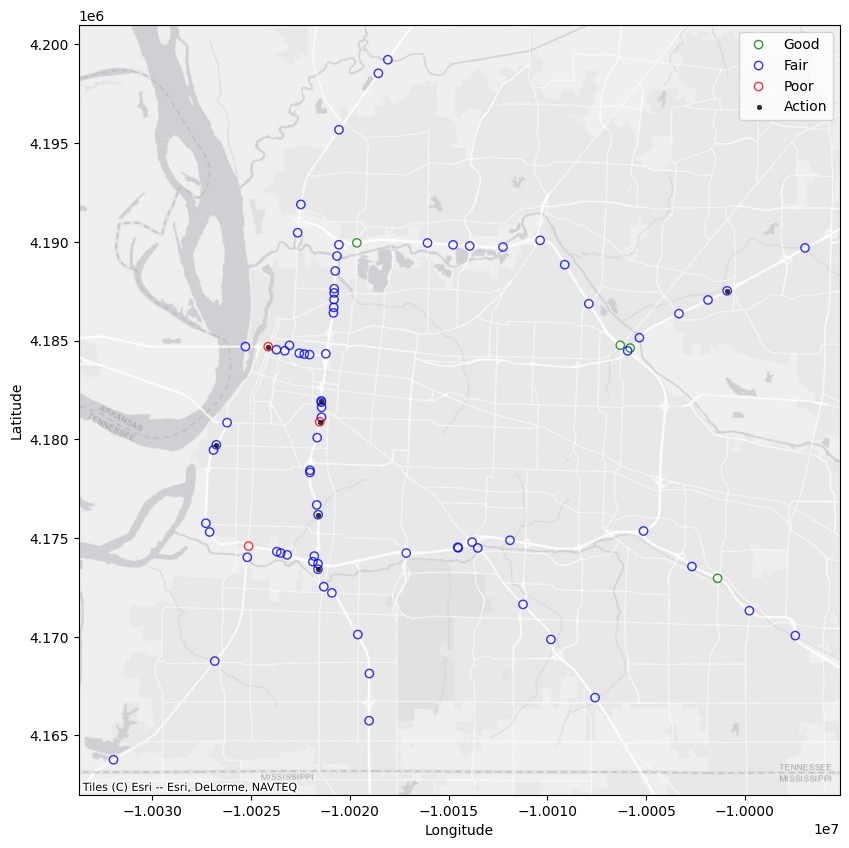

In [8]:
########### Print results and compare policies ############################

####################### P-PERDQN ##############################################################
sum_deck = np.sum(deck_area_Net)
#
#Deck_Area = self.num_spans * self.span_length * self.deck_width * (0.083*0.083)
total_C_Bridge = sum_deck*C_b   # 10.764 convert from meter square to feet square
budget = total_C_Bridge * budget_ratio
print('Available budget:', budget)
print('Remained_budget:', remained_budget)

y_budget = np.ones(years)*budget
x = range(years)
reward_stat_PERDQN = -np.asarray(reward_stat)

direct_stat_PERDQN = np.asarray(direct_stat)

indirect_stat_PERDQN = np.asarray(indirect_stat)

states_stat_PERDQN = np.asarray(states_stat)

flow_stat_PERDQN = np.asarray(flow_stat)

action_stat_PERDQN = np.asarray(action_stat)

x = range(years)
#PERDQN_NQ
#y_reward_PERDQN_B = np.zeros(years)
#y_direct_PERDQN_B = np.zeros(years)
#y_indirect_PERDQN_B = np.zeros(years)

y_reward_PERDQN = np.zeros(years)
y_direct_PERDQN = np.zeros(years)
y_indirect_PERDQN = np.zeros(years)
y_state_deck_PERDQN = np.zeros(years)
y_state_super_PERDQN = np.zeros(years)
y_state_sub_PERDQN = np.zeros(years)
Good_PERDQN = np.zeros(years)
Fair_PERDQN = np.zeros(years)
Poor_PERDQN = np.zeros(years)


############################################################################################################
############################################################################################################
flat_action_stat_PERDQN = action_stat_PERDQN.flatten()
flat_action_before= action_before.flatten()
# Unravel indices to get suggested actions
aa = np.unravel_index(flat_action_stat_PERDQN, (4, 4, 4))
aa_before = np.unravel_index(flat_action_before, (4, 4, 4))
# Mapping action indices to descriptions
action_mapping = {
    0: "Do nothing",
    1: "Minor",
    2: "Major",
    3: "Replacement"
}
indexed_arr = list(enumerate(ranks))  # [(0, 53), (1, 37), ...]

# Sort by the values in the array
sorted_indexed_arr = sorted(indexed_arr, key=lambda x: x[1])  # Sort by value

# Extract the sorted indices
sorted_indices = [index for index, value in sorted_indexed_arr]
sorted_indices = np.asarray(sorted_indices)
#print("Sorted Indices:", sorted_indices)
# Prepare the DataFrame
data = {
    "Bridge Number": list(range(len(deck_area_Net))),
    "Deck Action before": [action_mapping[x] for x in aa_before[0]],
    "Superstructure Action before": [action_mapping[x] for x in aa_before[1]],
    "Substructure Action before": [action_mapping[x] for x in aa_before[2]],
    "Direct cost": episode_C_dir_before.flatten(),
    "Ranking": (sorted_indices.flatten())+1,
    "Deck Action after": [action_mapping[x] for x in aa[0]],
    "Superstructure Action after": [action_mapping[x] for x in aa[1]],
    "Substructure Action after": [action_mapping[x] for x in aa[2]],
    "Applied direct cost": direct_stat.flatten()
}

sum_direct_cost = data["Direct cost"].sum()
sum_applied_direct_cost = data["Applied direct cost"].sum()

# Create a new row for the summation
summary_row = {
    "Bridge Number": "Total",
    "Deck Action before": "",
    "Superstructure Action before": "",
    "Substructure Action before": "",
    "Direct cost": sum_direct_cost,
    "Ranking": "",
    "Deck Action after": "",
    "Superstructure Action after": "",
    "Substructure Action after": "",
    "Applied direct cost": sum_applied_direct_cost,
    "": budget
}

df = pd.DataFrame(data)
# Append the summary row to the DataFrame
df = pd.concat([df, pd.DataFrame([summary_row])], ignore_index=True)


# Styling function for actions
def highlight_action(value):
    if value == "Minor":
        return "color: green"
    elif value == "Major":
        return "color: orange"
    elif value == "Replacement":
        return "color: red"
    else:
        return ""

# Apply styling
styled_df = df.style.applymap(highlight_action, subset=["Deck Action before", "Superstructure Action before", "Substructure Action before","Deck Action after", "Superstructure Action after", "Substructure Action after"])

# Display the styled DataFrame
#styled_df
# Display the DataFrame
#print(df)

styled_df.to_excel("bridge_actions.xlsx", index=False)
############################################################################################################
############################################################################################################
############################################################################################################









condition = []
action_suggested =[]

for j in range (len(times)):

    condition = []
    action_suggested =[]
    t_plot = times[j]
    for i in range(len(deck_area_Net)):
        if action_stat[0][i][t_plot]>0:
            action_suggested.append(1)
            if np.min(states_stat[0][i][t_plot][0:3])>=6:
                condition.append('Good')
            if np.min(states_stat[0][i][t_plot][0:3])==5 or np.min(states_stat[0][i][t_plot][0:3])==4:
                condition.append('Fair')
            if np.min(states_stat[0][i][t_plot][0:3])<4:
                condition.append('Poor')


        else:
            action_suggested.append(0)

            if np.min(states_stat[0][i][t_plot][0:3])>=6:
                condition.append('Good')

            if np.min(states_stat[0][i][t_plot][0:3])==5 or np.min(states_stat[0][i][t_plot][0:3])==4:
                condition.append('Fair')
            if np.min(states_stat[0][i][t_plot][0:3])<4:
                condition.append('Poor')


    df = pd.DataFrame({
        'Latitude': start_x,
        'Longitude': start_y,
        'Condition': condition,
        'Action Suggested': action_suggested
    })

    import geopandas as gpd
    from shapely.wkt import loads
    import contextily as cx
    dfgood = df[(df['Condition']=='Good')]
    dffair = df[(df['Condition']=='Fair')]
    dfpoor = df[(df['Condition']=='Poor')]
    dfaction = df[(df['Action Suggested']==1)]

    gdf_good = gpd.GeoDataFrame(
        dfgood, geometry=gpd.points_from_xy(dfgood.Longitude, dfgood.Latitude), crs="EPSG:4326"
    )
    gdf_fair = gpd.GeoDataFrame(
        dffair, geometry=gpd.points_from_xy(dffair.Longitude, dffair.Latitude), crs="EPSG:4326"
    )

    gdf_poor = gpd.GeoDataFrame(
        dfpoor, geometry=gpd.points_from_xy(dfpoor.Longitude, dfpoor.Latitude), crs="EPSG:4326"
    )

    gdf_action = gpd.GeoDataFrame(
        dfaction, geometry=gpd.points_from_xy(dfaction.Longitude, dfaction.Latitude), crs="EPSG:4326"
    )




    f, ax = plt.subplots(figsize=(10, 10))
    df_wm = gdf_good.to_crs(epsg=3857)
    df_wm.plot( alpha=0.8, color = "None", edgecolor="green", linewidth=1, ax = ax)
    df_wm = gdf_fair.to_crs(epsg=3857)
    df_wm.plot( alpha=0.8, color = "None", edgecolor="blue", linewidth=1, ax = ax)
    df_wm = gdf_poor.to_crs(epsg=3857)
    df_wm.plot( alpha=0.8, color = "None", edgecolor="red", linewidth=1, ax = ax)
    df_wm = gdf_action.to_crs(epsg=3857)
    df_wm.plot(alpha=0.8, color="k",marker =".",markersize = 40, linewidth=0.5, ax = ax)
    if len(gdf_good)>0:
        ax.legend(['Good'])
    if len(gdf_fair)>0:
        ax.legend(['Fair'])
    if len(gdf_poor)>0:
        ax.legend(['Poor'])
    if len(gdf_good)>0 and len(gdf_fair)>0 and len(gdf_poor)>0 and len(gdf_action)>0:
        ax.legend(['Good', 'Fair', 'Poor', 'Action'])
    if len(gdf_good)==0 and len(gdf_fair)>0 and len(gdf_poor)>0 and len(gdf_action)>0:
        ax.legend(['Fair', 'Poor', 'Action'])
    if len(gdf_good)>0 and len(gdf_fair)==0 and len(gdf_poor)>0 and len(gdf_action)>0:
        ax.legend(['Good', 'Poor', 'Action'])
    if len(gdf_good)>0 and len(gdf_fair)>0 and len(gdf_poor)==0 and len(gdf_action)>0:
        ax.legend(['Good', 'Fair', 'Action'])
    if len(gdf_good)>0 and len(gdf_fair)>0 and len(gdf_poor)>0 and len(gdf_action)==0:
        ax.legend(['Good', 'Fair', 'Poor'])


    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    #cx.add_basemap(ax, source=cx.providers.OpenStreetMap.Mapnik)
    #cx.add_basemap(ax,source=cx.providers.CartoDB.PositronNoLabels)
    cx.add_basemap(ax,source=cx.providers.Esri.WorldGrayCanvas)